# TITANIC SURVIVAL DATA PREDICTION

**The sinking of the Titanic is one of the most infamous shipwrecks in history.**

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

**We're going to take the following approach:**
1. problem defination
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation


## 1. THE PROBLEM DEFINATION

>what sorts of people were more likely to survive?

## 2. DATA

> You can get the data set used from https://www.kaggle.com/c/titanic/data 

## 3. EVALUATION

> If we can reach 95% accuracy.

## 4. FEATURES

* survival 	0 = No, 1 = Yes
* pclass = 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
* sex =	Sex 	
* Age =	Age in years 	
* sibsp = Number of siblings / spouses aboard the Titanic 	
* parch =	Number of parents / children aboard the Titanic 	
* ticket =	Ticket number 	
* fare =	Passenger fare 	
* cabin =	Cabin number 	
* embarked =	Port of Embarkation
 

## Preparing the tools


In [1]:
# Import all the tooks we need 

# Regular EDA and plotting libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
#we want plots to appear inside the nodebook
%matplotlib inline


In [2]:
# Model Evaluations
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV

#algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier

## LOADING DATA

In [31]:
titanic = pd.read_csv("../titanic/data/train.csv",index_col=0)
titanic.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [32]:
def cleanData(titanic):
    titanic['Age'] = titanic.groupby(['Pclass', 'Sex']).Age.apply(lambda x: x.fillna(x.mean()))
    titanic["Age"]=round(titanic["Age"])
    data = [titanic]
    for dataset in data:
        dataset['Age'] = dataset['Age'].astype(int)
        dataset.loc[ dataset['Age'] <= 11.0, 'Age'] = 0
        dataset.loc[(dataset['Age'] > 11.0) & (dataset['Age'] <= 18.0), 'Age'] = 1
        dataset.loc[(dataset['Age'] > 18.0) & (dataset['Age'] <= 22.0), 'Age'] = 2
        dataset.loc[(dataset['Age'] > 22.0) & (dataset['Age'] <= 27.0), 'Age'] = 3
        dataset.loc[(dataset['Age'] > 27.0) & (dataset['Age'] <= 33.0), 'Age'] = 4
        dataset.loc[(dataset['Age'] > 33.0) & (dataset['Age'] <= 40.0), 'Age'] = 5
        dataset.loc[(dataset['Age'] > 40.0) & (dataset['Age'] <= 66.0), 'Age'] = 6
        dataset.loc[ dataset['Age'] > 66.0, 'Age'] = 6
    titanic.drop(["Pclass","Ticket","Fare","Cabin","Embarked","Name"],axis=1,inplace=True)
    titanic['Sex'].replace("female", 0,inplace=True)
    titanic['Sex'].replace("male", 1,inplace=True)
    for dataset in data:
        dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
        dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
        dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
        dataset['not_alone'] = dataset['not_alone'].astype(int)
    return titanic

In [33]:
titanic = cleanData(titanic)
titanic.head()

,Survived,Sex,Age,SibSp,Parch,relatives,not_alone
PassengerId,,,,,,,
1,0,1,2,1,0,1,0
2,1,0,5,1,0,1,0
3,1,0,3,0,0,0,1
4,1,0,5,1,0,1,0
5,0,1,5,0,0,0,1


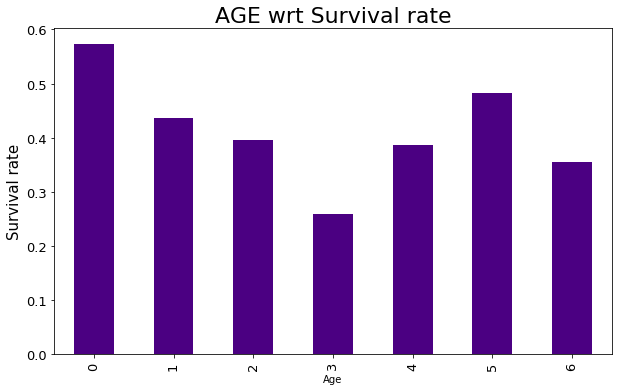

In [6]:
plot_graph= titanic.groupby(titanic["Age"])["Survived"].mean()
ax = plot_graph.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("AGE wrt Survival rate", fontsize=22)
ax.set_ylabel("Survival rate", fontsize=15);

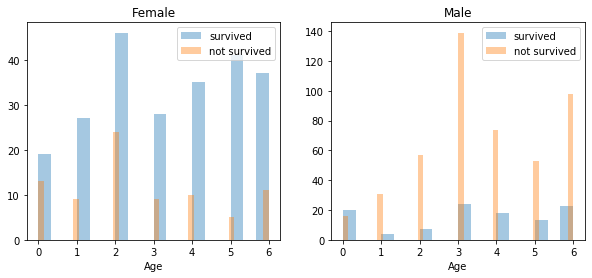

In [8]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = titanic[titanic['Sex']==0]
men = titanic[titanic['Sex']==1]
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')


In [9]:
data = [titanic]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
titanic['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

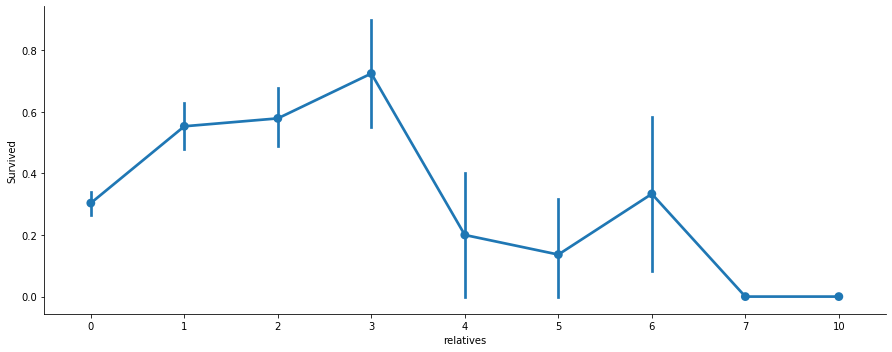

In [11]:
axes = sns.catplot('relatives','Survived', 
                      data=titanic, aspect = 2.5,kind=("point") )

In [12]:
np.random.seed(42)
x=titanic.drop("Survived",axis=1)
y=titanic.Survived
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.2,random_state=42)

In [257]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)

sgd.score(x_train, y_train)

acc_sgd = round(sgd.score(x_train, y_train) * 100, 2)
acc_sgd

75.0

In [19]:
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_*100, grid_result.best_params_))

Best: 82.116588 using {'max_features': 'log2', 'n_estimators': 1000}


In [310]:
logreg = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_*100, grid_result.best_params_))

Best: 79.303599 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [315]:
# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_*100, grid_result.best_params_))

Best: 79.211659 using {'alpha': 0.1}


In [17]:
# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_*100, grid_result.best_params_))

Best: 81.318466 using {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


In [13]:
# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_*100, grid_result.best_params_))

Best: 82.912754 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [14]:
# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 100, 1000]
# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_*100, grid_result.best_params_))

Best: 81.507564 using {'n_estimators': 1000}


In [15]:
# define models and parameters
model = GradientBoostingClassifier()
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.829577 using {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}


In [273]:
perceptron = Perceptron(max_iter=10)
perceptron.fit(x_train, y_train)

y_pred = perceptron.predict(x_test)

acc_perceptron = round(perceptron.score(x_train, y_train) * 100, 2)
acc_perceptron

/home/venom/Documents/machine-learning-projects/jupyter/titanic/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


63.48

In [282]:
linear_svc = LinearSVC(max_iter=4000,dual=False)
linear_svc.fit(x_train, y_train)

y_pred = linear_svc.predict(x_test)

acc_linear_svc = round(linear_svc.score(x_train, y_train) * 100, 2)
acc_linear_svc

79.21

In [20]:

decision_tree = DecisionTreeClassifier() 
decision_tree.fit(x_train, y_train)  
y_pred = decision_tree.predict(x_test)  
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

84.13

In [100]:
submissionDF=pd.read_csv("../titanic/data/test.csv")
submissionDF.copy()
cleaned_submission_DF=cleanData(submissionDF)
cleaned_submission=cleanData(sub)
submissionDF
cleaned_submission_DF
cleaned_submission_DF.drop("PassengerId",axis=1,inplace=True)

In [101]:
cleaned_submission

,PassengerId,Sex,Age,SibSp,Parch,relatives,not_alone
0,892,1,5,0,0,0,1
1,893,0,6,1,0,1,0
2,894,1,6,0,0,0,1
3,895,1,3,0,0,0,1
4,896,0,2,1,1,2,0
...,...,...,...,...,...,...,...
413,1305,1,3,0,0,0,1
414,1306,0,5,0,0,0,1
415,1307,1,5,0,0,0,1
416,1308,1,3,0,0,0,1


In [85]:
y_pred_new = decision_tree.predict(cleaned_submission_DF)

In [48]:
len(y_pred_new)

418

In [102]:
submission = pd.DataFrame({'Passengerid':cleaned_submission["PassengerId"],'Survived':y_pred_new})

submission

,Passengerid,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [103]:
filename = 'Titanic Predictions 1.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: Titanic Predictions 1.csv
